# Balanced Risk Set Matching

Journal: [Balanced Risk Set Matching](https://www.tandfonline.com/doi/abs/10.1198/016214501753208573) 

Reynat A. Daganta  
Ron Patrick G. Ramas


# I. Import Required Libraries

In [7]:
import numpy as np
import pandas as pd
from scipy.spatial.distance import cdist
from collections import defaultdict
import matplotlib.pyplot as plt

# II. Set Variables

In [18]:
np.random.seed(42)

number_of_patients = 400
evaluation_years = 4
evaluation_months = evaluation_years * 12
MAX_MATCHES = 100
BOX_TITLES = [
    'Baseline',
    'At Treatment',
    '3 Months after Treatment',
    '6 Months after Treatment',
    'Difference (3 mos posttreatment)',
    'Difference (6 mos posttreatment)'
]
BOX_LABELS = ['Never/Later Treated', 'Treated']

# III. Generate Baseline Data

In [19]:
baseline = pd.DataFrame({
    "patient_id": np.arange(0, number_of_patients),
    "gender": np.random.choice(['M', 'F'], number_of_patients),
    "pain": np.random.uniform(0, 10, number_of_patients),
    "urgency": np.random.uniform(0, 10, number_of_patients),
    "frequency": np.random.uniform(0, 20, number_of_patients)
})

# Display first few rows
baseline.head()

,patient_id,gender,pain,urgency,frequency
0,0,M,6.420316,1.689351,3.702659
1,1,F,0.841400,2.785903,10.838019
2,2,M,1.616287,1.770105,17.458917
3,3,M,8.985542,0.887025,14.644498
4,4,M,6.064291,1.206359,16.131223


# IV. Generate Evaluation Data

In [20]:
evaluations = pd.DataFrame()

for patient_id in range(number_of_patients):
    chosen_treatment_time = np.random.choice(list(np.arange(3, evaluation_months + 1, 3)) + [None])
    
    for month in range(3, evaluation_months + 1, 3):
        base_symptoms = baseline[baseline['patient_id'] == patient_id]
        
        pain = np.clip(base_symptoms['pain'].values[0] + np.random.normal(0, 1), 0, 10)
        urgency = np.clip(base_symptoms['urgency'].values[0] + np.random.normal(0, 1), 0, 10)
        frequency = np.clip(base_symptoms['frequency'].values[0] + np.random.normal(0, 2), 0, 20)
        
        if chosen_treatment_time and month >= chosen_treatment_time:
            treatment_effect = -np.random.uniform(0.5, 2)
            pain += treatment_effect
            urgency += treatment_effect
            frequency += treatment_effect * 2
        
        time_treated = chosen_treatment_time if chosen_treatment_time and month >= chosen_treatment_time else None
        treated = 1 if time_treated else 0

        evaluations = pd.concat([evaluations, pd.DataFrame({
            'patient_id': [patient_id],
            'pain': [pain],
            'urgency': [urgency],
            'frequency': [frequency],
            'time_since_entry': [month],
            'time_treated': [time_treated],
            'treated': [treated]
        })])

evaluations.groupby('patient_id')[['pain', 'urgency', 'frequency']].mean().head()

,pain,urgency,frequency
patient_id,,,
0,5.957615,1.300820,3.043254
1,0.611603,2.409865,9.401329
2,1.352161,1.404374,16.796093
3,8.133756,0.146627,12.339366
4,5.306384,0.402522,13.471759


# V. Generate Risk Sets

For each time point where a treatment occurs, we create two distinct groups: those receiving treatment at that time and potential controls who haven't yet been treated. This approach ensures proper temporal alignment in our comparisons and respects the dynamic nature of treatment assignment. 

In [21]:
risk_sets = {}

for time in evaluations['time_treated'].dropna().unique():
    treated = evaluations[
        (evaluations['time_since_entry'] == time) & 
        (evaluations['time_treated'] == time)
    ]
    
    untreated = evaluations[
        (evaluations['time_since_entry'] == time) & 
        (evaluations['treated'] == 0)
    ]

    risk_sets[time] = (treated, untreated)

print(f"Number of risk sets: {len(risk_sets)}")
print(f"Available time points: {sorted(risk_sets.keys())}")

Number of risk sets: 16
Available time points: [3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 33, 36, 39, 42, 45, 48]


# VI. Binary Variable Functions

Each symptom variable is divided into three groups (lower, middle, and upper thirds), and binary indicators are created for the middle and upper groups. This system is applied to both current and baseline symptoms, creating a comprehensive set of balance criteria. 

In [22]:
def create_bin_var(df, variables):
    binary_vars = defaultdict(list)
    for var in variables:
        lower_percentile = np.percentile(df[var], 33)
        upper_percentile = np.percentile(df[var], 67)

        binary_middle = ((df[var] > lower_percentile) & 
                        (df[var] <= upper_percentile)).astype(int)
        binary_upper = (df[var] > upper_percentile).astype(int)
        
        binary_vars[f"{var}_middle"].extend(binary_middle)
        binary_vars[f"{var}_upper"].extend(binary_upper)

    return pd.DataFrame(binary_vars)

variables = [
    'pain_current', 'urgency_current', 'frequency_current',
    'pain_baseline', 'urgency_baseline', 'frequency_baseline'
]

new_rs = {}
for key, (t, u) in risk_sets.items():
    treated = t.merge(
        baseline, 
        on='patient_id', 
        suffixes=['_current', '_baseline']
    )
    bin_t = create_bin_var(treated, variables)
    treated = pd.concat([treated, bin_t], axis=1)

    untreated = u.merge(
        baseline, 
        on='patient_id', 
        suffixes=['_current', '_baseline']
    )
    bin_u = create_bin_var(untreated, variables)
    untreated = pd.concat([untreated, bin_u], axis=1)

    new_rs[key] = (treated, untreated)

print("Features in processed datasets:")
print(list(new_rs.values())[0][0].columns)

Features in processed datasets:
Index(['patient_id', 'pain_current', 'urgency_current', 'frequency_current',
       'time_since_entry', 'time_treated', 'treated', 'gender',
       'pain_baseline', 'urgency_baseline', 'frequency_baseline',
       'pain_current_middle', 'pain_current_upper', 'urgency_current_middle',
       'urgency_current_upper', 'frequency_current_middle',
       'frequency_current_upper', 'pain_baseline_middle',
       'pain_baseline_upper', 'urgency_baseline_middle',
       'urgency_baseline_upper', 'frequency_baseline_middle',
       'frequency_baseline_upper'],
      dtype='object')


# VII. Matching Implementation

In [23]:
def compute_distance(treated, untreated, covariates):
    treated_matrix = treated[covariates].to_numpy()
    untreated_matrix = untreated[covariates].to_numpy()
    
    cov_matrix = np.cov(np.vstack([treated_matrix, untreated_matrix]).T)
    
    if np.linalg.det(cov_matrix) < 1e-10:
        cov_matrix += np.eye(cov_matrix.shape[0]) * 1e-6
    
    return cdist(
        treated_matrix, 
        untreated_matrix, 
        metric='mahalanobis',
        VI=np.linalg.inv(cov_matrix)
    )

distance_dict = defaultdict(list)

for key, (t, u) in new_rs.items():
    distance_matrix = compute_distance(t, u, variables)
    
    for i, row in enumerate(distance_matrix):
        for j, distance in enumerate(row):
            distance_dict[distance].append(
                (int(t['patient_id'].iloc[i]), 
                 int(u['patient_id'].iloc[j]))
            )

mcf_avg_distance = sum(distance_dict.keys()) / len(distance_dict.keys())
print(f"Average Mahalanobis distance: {mcf_avg_distance:.2f}")

# Create matches from Minimum Cost Flow (top 100)
mcf_matches = []
count = 0

for keys in sorted(distance_dict.keys()):
    for match in distance_dict[keys]:
        if count >= MAX_MATCHES:
            break
        mcf_matches.append(match)
        count += 1

print("\nFirst 5 matches:")
print(mcf_matches[:5])

Average Mahalanobis distance: 3.75

First 5 matches:
[(93, 175), (125, 131), (282, 345), (91, 139), (255, 63)]


# VIII. Balanced Pair Matching

The algorithm assigns group scores based on our binary variables and matches patients with identical scores. A careful tracking system prevents any patient from being matched multiple times while maintaining the overall balance of covariates between groups

In [24]:
def find_group(series, variables):
    total = 0
    for i, var in enumerate(variables):
        total += (i + 1) * series.loc[var]
    return total

bpm_matches = []
patient_set = set()
count = 0

var = [f"{x}_middle" for x in variables] + [f"{x}_upper" for x in variables]

for (t, u) in new_rs.values():
    for i in range(t.shape[0]):
        for j in range(u.shape[0]):
            if count < MAX_MATCHES and find_group(t.iloc[i], var) == find_group(u.iloc[j], var):
                t_id = int(t['patient_id'].iloc[i])
                u_id = int(u['patient_id'].iloc[j])
                
                if t_id not in patient_set and u_id not in patient_set:
                    bpm_matches.append((t_id, u_id))
                    patient_set.add(t_id)
                    patient_set.add(u_id)
                    count += 1

print(f"Number of balanced matches found: {len(bpm_matches)}")

Number of balanced matches found: 100


# IX. Analysis Functions

In [26]:
def find_dataframes(match):
    x, y = match
    features = ['pain', 'urgency', 'frequency']
    
    baseline_match_x = baseline[baseline['patient_id'] == x][features]
    baseline_match_y = baseline[baseline['patient_id'] == y][features]
    
    features.append('treated')
    
    treatment_match_x = evaluations[
        (evaluations['patient_id'] == x) & 
        (evaluations['time_treated'] == evaluations['time_since_entry'])
    ][features + ['time_since_entry']]
    
    time_since_entry = (treatment_match_x['time_since_entry'].iloc[0] 
                       if not treatment_match_x['time_since_entry'].empty 
                       else -1)
    
    if time_since_entry == -1:
        return ()
        
    treatment_match_x = treatment_match_x.drop('time_since_entry', axis=1)
    treatment_match_y = evaluations[
        (evaluations['patient_id'] == y) & 
        (evaluations['time_since_entry'] == time_since_entry)
    ][features]
    
    time_3m = time_since_entry + 3
    _3m_match_x = evaluations[
        (evaluations['patient_id'] == x) & 
        (evaluations['time_since_entry'] == time_3m)
    ][features]
    _3m_match_y = evaluations[
        (evaluations['patient_id'] == y) & 
        (evaluations['time_since_entry'] == time_3m)
    ][features]
    
    time_6m = time_since_entry + 6
    _6m_match_x = evaluations[
        (evaluations['patient_id'] == x) & 
        (evaluations['time_since_entry'] == time_6m)
    ][features]
    _6m_match_y = evaluations[
        (evaluations['patient_id'] == y) & 
        (evaluations['time_since_entry'] == time_6m)
    ][features]
    
    return (
        baseline_match_x, baseline_match_y,
        treatment_match_x, treatment_match_y,
        _3m_match_x, _3m_match_y,
        _6m_match_x, _6m_match_y
    )

dataframes = [pd.DataFrame() for _ in range(12)]

treatment_index = 2
month_index = 4

for match in bpm_matches:
    data = find_dataframes(match)
    
    if len(data) == 0:
        continue
        
    for i in range(len(dataframes) - 4):
        dataframes[i] = pd.concat([dataframes[i], data[i]])
    
    for i in range(4):
        index = len(dataframes) - 4 + i
        dataframes[index] = pd.concat([
            dataframes[index], 
            data[month_index + i] - data[treatment_index + (i // 2)]
        ])

for index in range(len(dataframes)):
    dataframes[index] = dataframes[index].dropna()

# X. Visualization

Through a series of boxplots, we can examine the distribution of symptoms across groups at each timepoint.

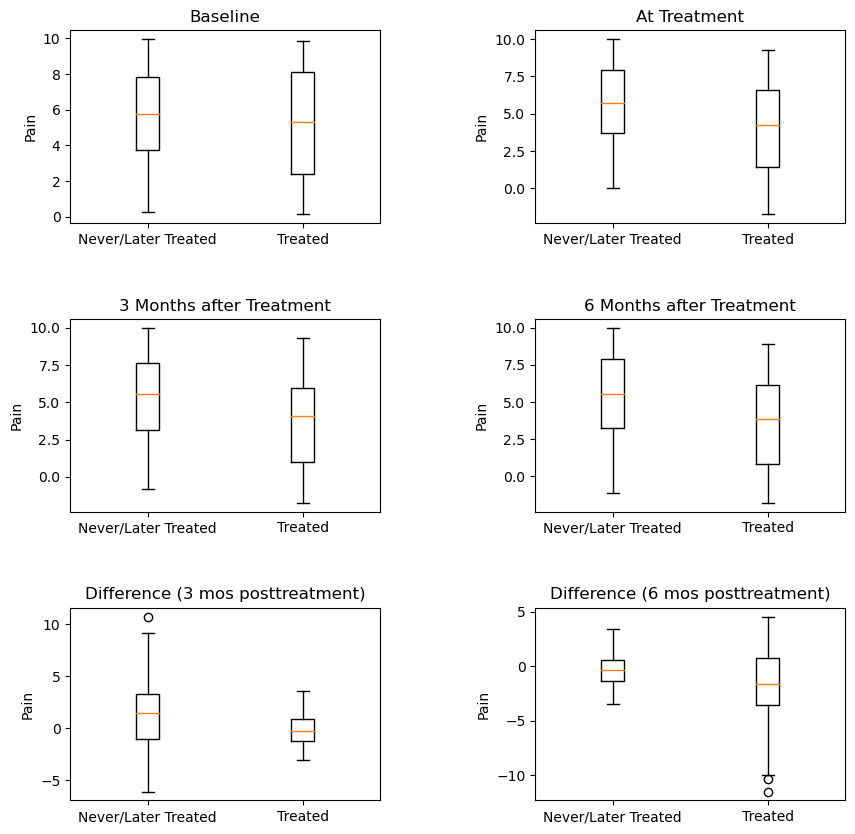

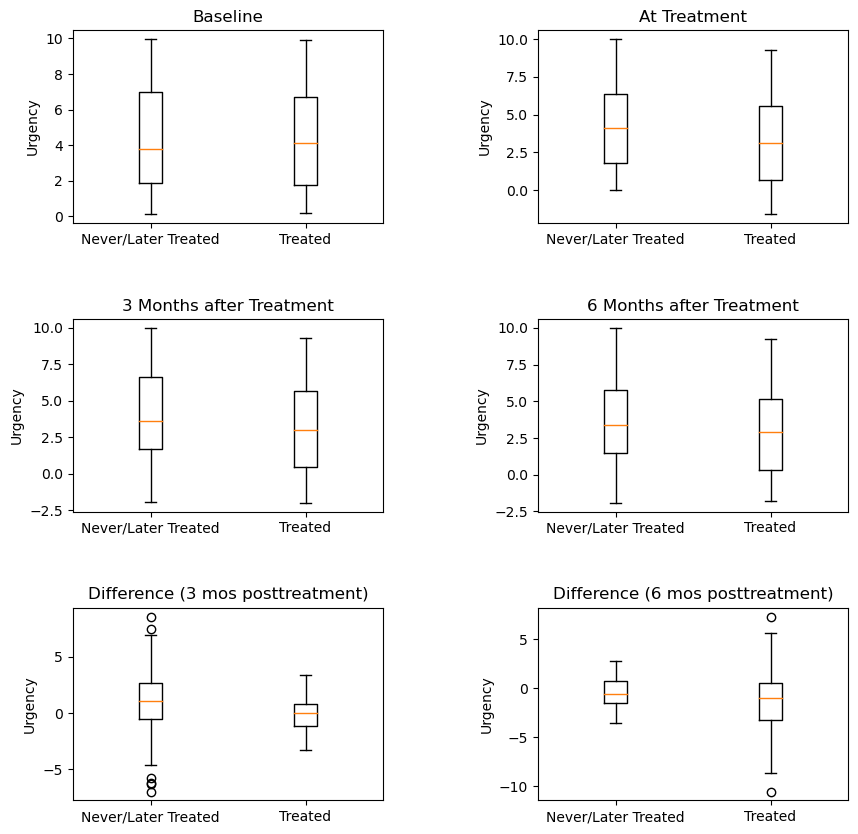

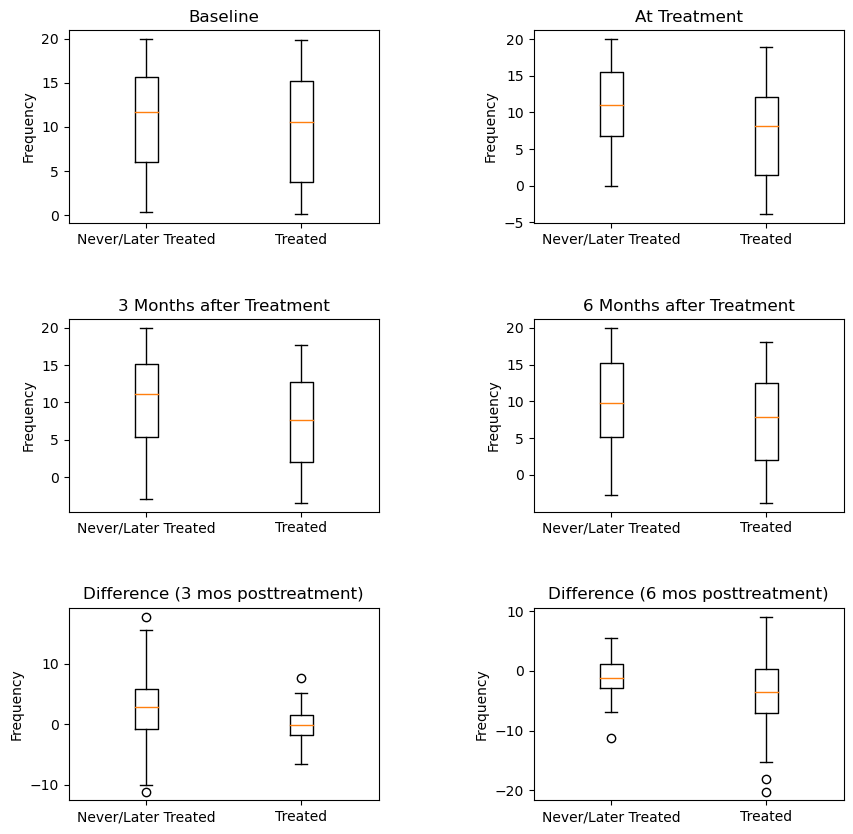

In [27]:
def display_boxplots(column, title):
    fig, axes = plt.subplots(len(dataframes) // 4, 2, figsize=(10, 10))
    
    for i in range(0, len(dataframes), 2):    
        actual_index = i // 2
        axes_row = actual_index // 2
        axes_col = actual_index % 2
        
        axes[axes_row, axes_col].boxplot([
            dataframes[i + 1].loc[:, column], 
            dataframes[i].loc[:, column]
        ])
        axes[axes_row, axes_col].set_title(BOX_TITLES[i // 2])
        axes[axes_row, axes_col].set_ylabel(title)
        axes[axes_row, axes_col].set_xticks([1, 2], BOX_LABELS)

    plt.subplots_adjust(wspace=0.5, hspace=0.5)
    plt.show()
   
# Create visualizations for each symptom
for symptom in ['pain', 'urgency', 'frequency']:
    display_boxplots(symptom, symptom.capitalize())